In [ ]:
# Import all requirements
import torch
import timm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
from torchvision.datasets import DatasetFolder
from torch.utils.data import Subset
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Define transformations for the dataset
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [3]:
# Load dataset (Ensure dataset is structured in subfolders per class)
dataset = ImageFolder(root=os.path.join(os.getcwd(), "Dataset"), transform=data_transforms)

# Split dataset into train and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.targets)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [4]:
# Load pre-trained Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {train_acc}%")
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        print(f"Validation Accuracy: {val_acc}%")


In [ ]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

c:\Users\jayak\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jayak\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch 1, Loss: 1.9375053524971009, Accuracy: 43.75%
Validation Accuracy: 50.0%
Epoch 2, Loss: 0.7754625916481018, Accuracy: 53.75%
Validation Accuracy: 50.0%
Epoch 3, Loss: 0.7152973175048828, Accuracy: 46.875%
Validation Accuracy: 52.5%
Epoch 4, Loss: 0.6319679379463196, Accuracy: 67.5%
Validation Accuracy: 77.5%
Epoch 5, Loss: 0.4027891993522644, Accuracy: 91.875%
Validation Accuracy: 100.0%
Epoch 6, Loss: 0.09059782922267914, Accuracy: 98.125%
Validation Accuracy: 87.5%
Epoch 7, Loss: 0.14969760766252876, Accuracy: 95.625%
Validation Accuracy: 100.0%
Epoch 8, Loss: 0.08590059289708733, Accuracy: 96.875%
Validation Accuracy: 100.0%
Epoch 9, Loss: 0.020633973646909, Accuracy: 99.375%
Validation Accuracy: 92.5%
Epoch 10, Loss: 0.0009322177385911346, Accuracy: 100.0%
Validation Accuracy: 97.5%


In [ ]:
torch.save(model.state_dict(), "vit_model.pth")
print("Model saved as vit_model.pth")


Model saved as vit_model.pth


In [ ]:
# Load the saved model
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("vit_model.pth"))
model.to(device)
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print("Confusion Matrix:")
print(conf_matrix)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Confusion Matrix:
[[19  1]
 [ 0 20]]
F1 Score: 0.9749843652282676
Precision: 0.9761904761904763
Recall: 0.975


In [ ]:

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



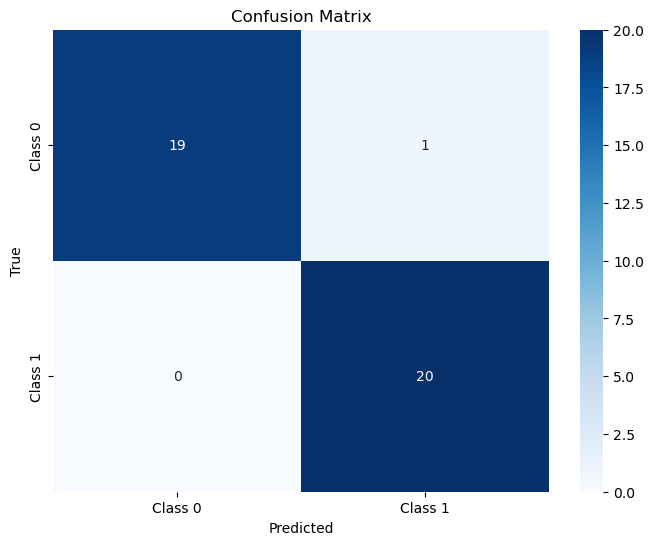

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()